# Description
### This notebook is designed to show uses of formal_tests.py, a script designed to present some robust information regarding the barotropic model. For example, understanding the required number of ensemble members to sample the forcing, and finding the zonally symmetric climatological variance caused by the forcing.

In [1]:
#import packages
%matplotlib notebook

import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path
from model.solver import Solver #bm3_barotropic_model packages
from model.sphere import Sphere
from model.forcing import Forcing

from utils import constants, plotting
import ensemble_methods as em

import time
import numpy as np
import random
import xarray as xr

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    

from tqdm import tqdm



/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.1) Do the basic properties of the model align with previous studies?

integrating for 41.7 days with a dt of 0.50 hours
output freq of 3.00 hours
integrating with:  nu= 1000000000000000.0 diffusion_order= 2


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 233.91it/s]


<IPython.core.display.Javascript object>


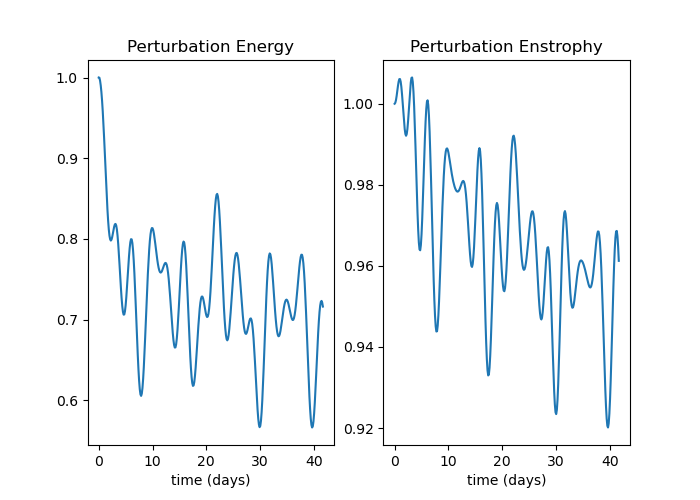

array([<AxesSubplot:title={'center':'Perturbation Energy'}, xlabel='time (days)'>,
       <AxesSubplot:title={'center':'Perturbation Enstrophy'}, xlabel='time (days)'>],
      dtype=object)

In [5]:
dt = 1800 #time between integration steps (seconds)
Nt = 2000 #number of integration steps

T= Nt*dt #total integration time
print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

ofreq = 6 #frequency of integration output in resulting ds
print('output freq of {:.2f} hours'.format(dt*s2h*ofreq))

M = 63
st = Sphere(M, base_state='held85')

F = Forcing(st,dt,T)
forcing_tseries = F.generate_zeroforcing_tseries()

k0=3 #if we want to start with some structure in the vorticity here's an option
vortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

thetap = np.zeros(vortp.shape) #no temp perturbation
st.set_ics([vortp,thetap])

# Turn off frictional dissipation, thermal relaxation, add viscosity values from Held 1985
#params = dict(rs = 0., tau = 0., nu = 1e4, diffusion_order=1, robert_filter=0.01)

# Turn off frictional dissipation, add viscosity values from Held and Phillips 1987
params = dict(rs = 0., nu = 1e15, diffusion_order=2)

#choose whether we integrate with a linear temp/vorticity field. temp_linear=False uses nonlinear advection
S = Solver(st, forcing=F, ofreq=ofreq, **params)

sln = S.integrate_dynamics(temp_linear=True, vort_linear=False)

plotters.plot_energy(sln)
#plt.title('Held 1985 comparison')

## 2.1 Check how many members are needed to sample forcing well
Here we run just the red noise forcing out to 10 years to represent the climatological spread. Then, an ensemble of size e, of the forcing equation is generated for a single timestep. The variance of the ensemble represents the ability for an ensemble of size e to produce the climatological spread at any given time. This is repeated for a couple hundred runs to capture the spread of the estimated variance. Results for a single coordinate are plotted below; i've picked the a location that aligns with our stirring latitude. Small ensembles initially underestimate the climatological variance, but quickly asymptote to the climatology value. As the ensemble size increases, the spread in the estimated variance decreases as well. 200 seems like a pretty good number?

In [20]:
T = 10*365*constants.day2sec #climatology run (10 yrs)
st= Sphere(base_state='solid')
fcli = Forcing(sphere=st)

dt=4000
fcli_tseries = np.empty((T//dt, st.nspecindx)) 
for t in tqdm(range(0,T//dt)):
    fcli_tseries[t,:]=fcli.evolve_rededdy(dt=dt)

# generate an ensemble of 10000 mem. 
max_mem = 10000

ens_force = np.empty((max_mem, st.nspecindx)) #ensemble samples

for nm in tqdm(range(max_mem)):
    fmem = Forcing(sphere=st)
    ens_force[nm]=fmem.evolve_rededdy()


  0%|                                                 | 0/78840 [00:00<?, ?it/s]/tmp/ipykernel_9333/3940257609.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  fcli_tseries[t,:]=fcli.evolve_rededdy(dt=dt)
  0%|                                                 | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_9333/3940257609.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  ens_force[nm]=fmem.evolve_rededdy()
100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1230.41it/s]


<IPython.core.display.Javascript object>


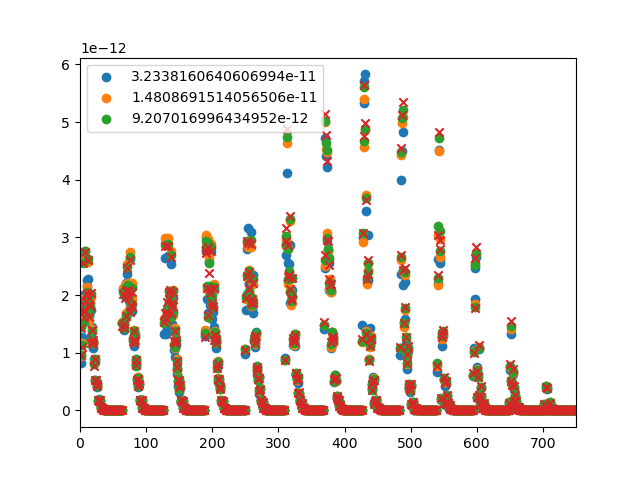

<IPython.core.display.Javascript object>


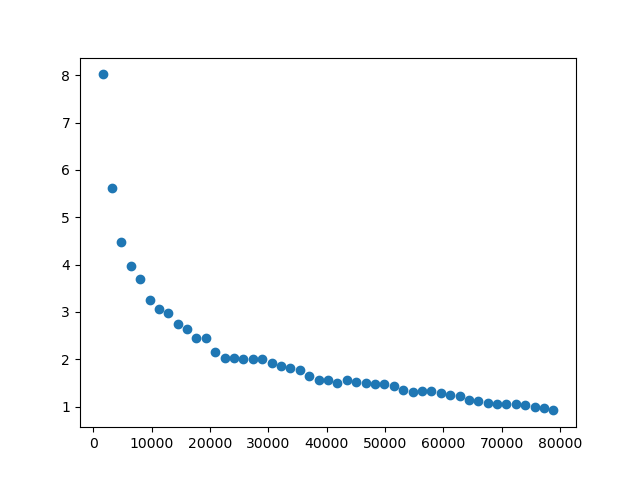

In [22]:
plt.figure()
cuts = [10000,50000,1000000]
for cut in cuts:
    lab = sum(abs(fcli_tseries[:cut,:].std(axis=0) - ens_force[:,:].std(axis=0)))
    plt.scatter(x= range(st.nspecindx), y=fcli_tseries[:cut,:].std(axis=0), label=lab)

plt.scatter(x= range(st.nspecindx), y=ens_force[:,:].std(axis=0), marker='x')
plt.xlim(0,750)
plt.legend()
plt.show()


plt.figure()
cuts = np.linspace(0,len(fcli_tseries),50).astype(int)
scale = 1e11
ys = []
for cut in cuts:
    #print(cut)
    ys.append(sum(abs(fcli_tseries[:cut,:].std(axis=0) - ens_force[:,:].std(axis=0))))

plt.scatter(cuts, np.array(ys)*scale)
plt.show()

<IPython.core.display.Javascript object>


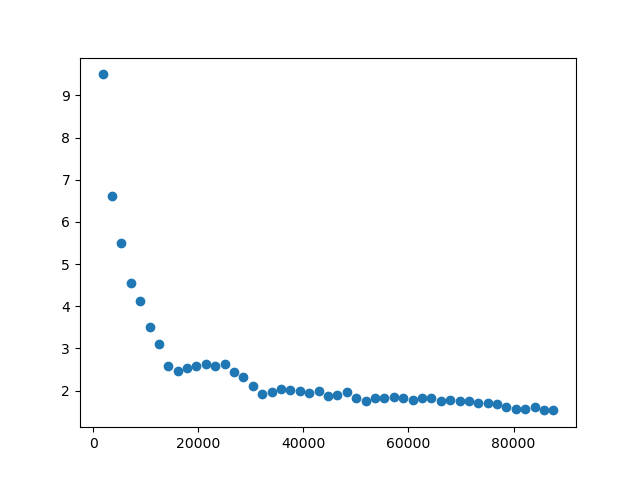

In [18]:
plt.figure()
plt.scatter(cuts, np.array(ys)*scale)
plt.show()

In [27]:
fig,axs = plt.subplots(1,1,figsize=(3,3))

clim = fcli.std(axis=0).mean(axis=-1)
yy,xx=17,50
#fensp= fens[:,:,yy,xx]

x=n_ens
mu = np.array([ fensp[:,n].mean() for n in range(len(x)) ])
sig =np.array([ fensp[:,n].std() for n in range(len(x)) ])
axs.plot(x, gf1d(mu, sigma=0.01), color = 'k', label = 'ens. std($\mathcal{F}$)')
axs.plot(x, gf1d(mu+sig, sigma=0.01), color = 'k',linestyle='--')
axs.plot(x, gf1d(mu-sig, sigma=0.01), color = 'k',linestyle='--')
axs.axhline(clim[yy] ,linestyle='--',color='r', label = 'clim. std($\mathcal{F}$)')

axs.set_xlabel('ensemble size')
axs.set_ylabel('Forcing Std.')

axs.set_title('coord: ({:.0f}N,{:.0f}E)'.format(np.linspace(90,-90,nlat)[yy],(360./nlon*np.arange(nlon))[xx]))
axs.set_xlim(0.,max(n_ens))
# ss= np.empty((len(x),fens.shape[2]))
# for i,n in enumerate(x):
#     ss[i]=fens[:n,:-1,:,:].std(axis=0).mean(axis=(0,-1))
    
# cf= axs[1].pcolormesh(range(nlat),x, abs(clim-ss)/clim*100., vmax=10)

# plt.colorbar(cf,ax=axs[1])
plt.legend()
plt.tight_layout()
plt.show()

array([[ 5.44779282e-13,  1.31519172e-13, -4.07579027e-13, ...,
        -5.63803977e-24, -6.80730517e-22,  4.52315614e-23],
       [-2.24661950e-13,  1.09926879e-12,  4.39934493e-13, ...,
         4.16011510e-23,  5.38223211e-22, -1.42774383e-22],
       [-2.49072507e-12,  5.32425720e-13,  2.89225810e-13, ...,
         5.09644383e-22,  1.74565260e-21,  1.66956273e-23],
       ...,
       [-2.70017060e-12, -2.33632189e-12, -1.18586857e-12, ...,
         4.29916117e-22,  2.06427216e-22, -2.02794417e-22],
       [-1.06356699e-12,  1.46660331e-12, -1.16182942e-12, ...,
        -8.14521162e-23,  1.97511444e-21,  6.82146427e-22],
       [-9.59520224e-13,  2.41758545e-13, -4.82495933e-13, ...,
        -3.18437853e-22,  8.99005275e-22,  2.56039032e-22]])

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(3,3))

clim = fcli.std(axis=0).mean(axis=-1)
yy,xx=17,50
fensp= fens[:,:,yy,xx]

x=n_ens
mu = np.array([ fensp[:,n].mean() for n in range(len(x)) ])
sig =np.array([ fensp[:,n].std() for n in range(len(x)) ])
axs.plot(x, gf1d(mu, sigma=0.01), color = 'k', label = 'ens. std($\mathcal{F}$)')
axs.plot(x, gf1d(mu+sig, sigma=0.01), color = 'k',linestyle='--')
axs.plot(x, gf1d(mu-sig, sigma=0.01), color = 'k',linestyle='--')
axs.axhline(clim[yy] ,linestyle='--',color='r', label = 'clim. std($\mathcal{F}$)')

axs.set_xlabel('ensemble size')
axs.set_ylabel('Forcing Std.')

axs.set_title('coord: ({:.0f}N,{:.0f}E)'.format(np.linspace(90,-90,nlat)[yy],(360./nlon*np.arange(nlon))[xx]))
axs.set_xlim(0.,max(n_ens))
# ss= np.empty((len(x),fens.shape[2]))
# for i,n in enumerate(x):
#     ss[i]=fens[:n,:-1,:,:].std(axis=0).mean(axis=(0,-1))
    
# cf= axs[1].pcolormesh(range(nlat),x, abs(clim-ss)/clim*100., vmax=10)

# plt.colorbar(cf,ax=axs[1])
plt.legend()
plt.tight_layout()
plt.show()

## 2.2 Derive Climatological Spread
### I found that running one very long climatology produced relatively large zonal variation in mean variance. It was slightly more efficient to run an ensemble (100) of 5 year simulations and average the runs to find the mean variance (I think due to the relatively long memory of the eddies, it takes a while to kill off preferential spatial features?). This also gives us a way to estimate the variance of the mean variance, which can help with formally justifying when an ensemble approaches the climatology. 

integrating for  365.0  days, with a dt of  0.046296296296296294  days


100%|█████████████████████████████████████████████| 2/2 [01:28<00:00, 44.21s/it]


<IPython.core.display.Javascript object>


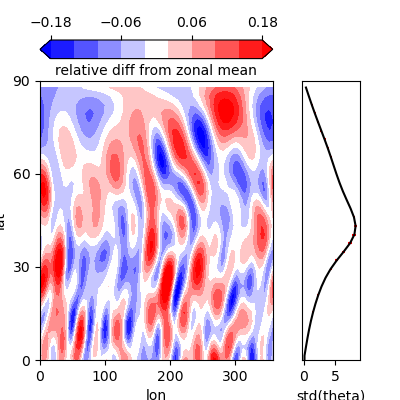

In [2]:
dt = 4000 #time between integration steps (seconds)
#nlat=64; nlon=128
M=63
params=dict(nu=0., Kappa=0., tau = 1/8, diffusion_order=4)


clim= ft.climatological_spread(M,dt,A=1e-11,produce_plots=False, **params)
#clim = xr.open_dataset('../climatology.nc')

# Start with a square Figure.
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1,15),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.15)

ax = fig.add_subplot(gs[1, 0])
cbarax = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1, 1])

clev=np.arange(-0.18,0.19,0.04)
cf=ax.contourf(clim.x.values,clim.y.values, (clim.theta.mean('runs')-clim.theta.mean(['x','runs']))/clim.theta.mean(['x','runs']) ,
               cmap='bwr',levels=clev, extend='both')



cb=plt.colorbar(cf, cax=cbarax,orientation='horizontal', spacing='uniform',
                label='relative diff from zonal mean')
cb.set_ticks(clev[::3])
cb.ax.xaxis.set_ticks_position('top')

ax2.errorbar(clim.theta.mean(['x','runs']), clim.y.values, xerr=2*clim.theta.mean('x').std('runs'),
             color='k', ecolor='r')


ax.set_ylabel('lat')
ax.set_xlabel('lon')
ax.set_yticks(np.arange(0,91,30))
ax.set_ylim(0,90)

ax2.set_xlabel('std(theta)')
ax2.set_yticks([])
ax2.set_ylim(0,90)

plt.show()

In [5]:
clim.to_netcdf('../climatology_linear.nc')

In [4]:
ics = clim.isel(runs=0)
ics

<xarray.Dataset>
Dimensions:  (y: 64, x: 127)
Coordinates:
  * y        (y) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * x        (x) float64 0.0 2.835 5.669 8.504 11.34 ... 348.7 351.5 354.3 357.2
Data variables:
    vort     (y, x) float64 1.076e-06 1.079e-06 ... 9.533e-07 9.456e-07
    vortp    (y, x) float64 1.076e-06 1.079e-06 ... 9.533e-07 9.456e-07
    u        (y, x) float64 2.143 2.135 2.128 2.121 ... 2.119 2.122 2.125 2.129
    v        (y, x) float64 2.093 2.092 2.09 2.089 ... 2.253 2.264 2.275 2.285
    thetap   (y, x) float64 0.2966 0.2943 0.2923 0.2905 ... 0.2997 0.3043 0.309
    theta    (y, x) float64 0.2966 0.2943 0.2923 0.2905 ... 0.2997 0.3043 0.309

## 1.3 Check to see how long it takes for ensemble to approach climatology
### Using our derived climatology from 1.2, and an ensemble of size 200, lets run a 6-week long simulation and see how our ensemble behaves.

In [ ]:
M = 63
st = Sphere(M, base_state='solid')

F = Forcing(st,dt,T)
Si = F.generate_rededdy_start() #initial forcing
forcing_tseries = F.generate_rededdy_tseries(A=1e-11,Si=Si) #evolve forcing
#forcing_tseries = F.generate_zeroforcing_tseries()

k0=3 #if we want to start with some structure in the vorticity here's an option
vortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

Pvortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 -0.5 * (st.glons - 60.)**2 / 10**2 )

#vortp = np.zeros(thetap.shape)
thetap = np.zeros(vortp.shape) #we'll start with t0=background state
st.set_ics([vortp,thetap])

params=dict(nu=0., Kappa=0., tau = 1/8, diffusion_order=3)

# Turn off frictional dissipation, thermal relaxation, add viscosity values from Held 1985
#params = dict(rs = 0., tau = 0., nu = 1e4, diffusion_order=1, robert_filter=0.01)

# Turn off frictional dissipation, add viscosity values from Held and Phillips 1987
#params = dict(rs = 0., nu = 1e15, diffusion_order=2)

#choose whether we integrate with a linear temp/vorticity field. temp_linear=False uses nonlinear advection
S = Solver(st, forcing=F, ofreq=ofreq, **params)

sln = S.integrate_dynamics(temp_linear=False, vort_linear=False)

In [10]:
num_members= 100 #num of members in the ensemble
dt = 4000 #time between integration steps (seconds)
d2s = 86400
T= d2s*7*6 #total integration time
#nlat=64; nlon=128
M = 63
nlon = 2*M + 1
nlat = M + 1
ofreq=3
params=dict(nu=0., Kappa=0., tau = 1/8, diffusion_order=3)


thetap = np.zeros((nlat,nlon))
vortp = np.zeros((nlat,nlon))

st = Sphere(M, base_state='solid')
F = Forcing(st,dt,T)
Si = F.generate_rededdy_start() #initial forcing
forcing_tseries = F.generate_rededdy_tseries(A=1e-11,Si=Si) #evolve forcing

S = Solver(st, forcing=F, ofreq=ofreq, **params)
sln = S.integrate_dynamics(temp_linear=True, vort_linear=True)


#ics = np.array([vortp,thetap])
ics = np.array([sln.isel(time=-1).vortp.values, sln.isel(time=-1).thetap.values])

ensemble = ensemble_methods.integrate_ensemble(M, dt=dt, T=T, ofreq=ofreq, ics=ics, A=1e-11,
                                               n_ens=num_members, temp_linear=True,
                                               vort_linear=True, vortpert=0., **params)

clims= xr.open_dataset('../climatology_linear.nc')#.mean('x')


100%|█████████████████████████████████████████| 100/100 [07:45<00:00,  4.66s/it]


<IPython.core.display.Javascript object>


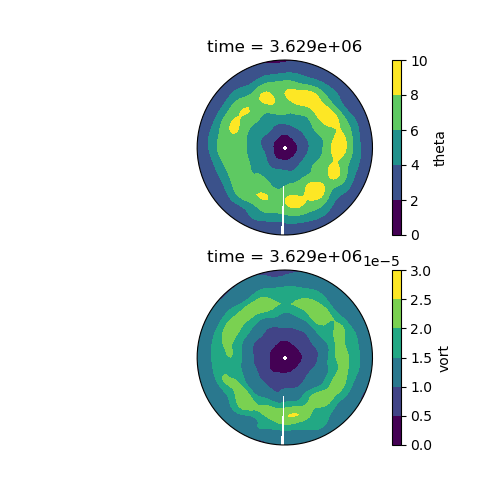

In [11]:
fig = plt.figure(figsize=(5,5))
proj=ccrs.NorthPolarStereo()
xy=(105,40)

ax1 = plt.subplot(2,1,1, projection = proj) #axes for map
ax1.set_extent([-179.9, 179.9, 20, 90], crs=ccrs.PlateCarree())
ax2 = plt.subplot(2,1,2, projection = proj) #axes for map
ax2.set_extent([-179.9, 179.9, 20, 90], crs=ccrs.PlateCarree())
plotters.make_ax_circular(ax1)
plotters.make_ax_circular(ax2)

ensemble.isel(time=-1).theta.std('ens_mem').plot.contourf(ax=ax1, transform=ccrs.PlateCarree())
ensemble.isel(time=-1).vort.std('ens_mem').plot.contourf(ax=ax2, transform=ccrs.PlateCarree())

# ax1.contourf(ensemble.x, ensemble.y,ensemble.isel(time=-1).theta.std('ens_mem'),
#              transform=ccrs.PlateCarree())

<IPython.core.display.Javascript object>


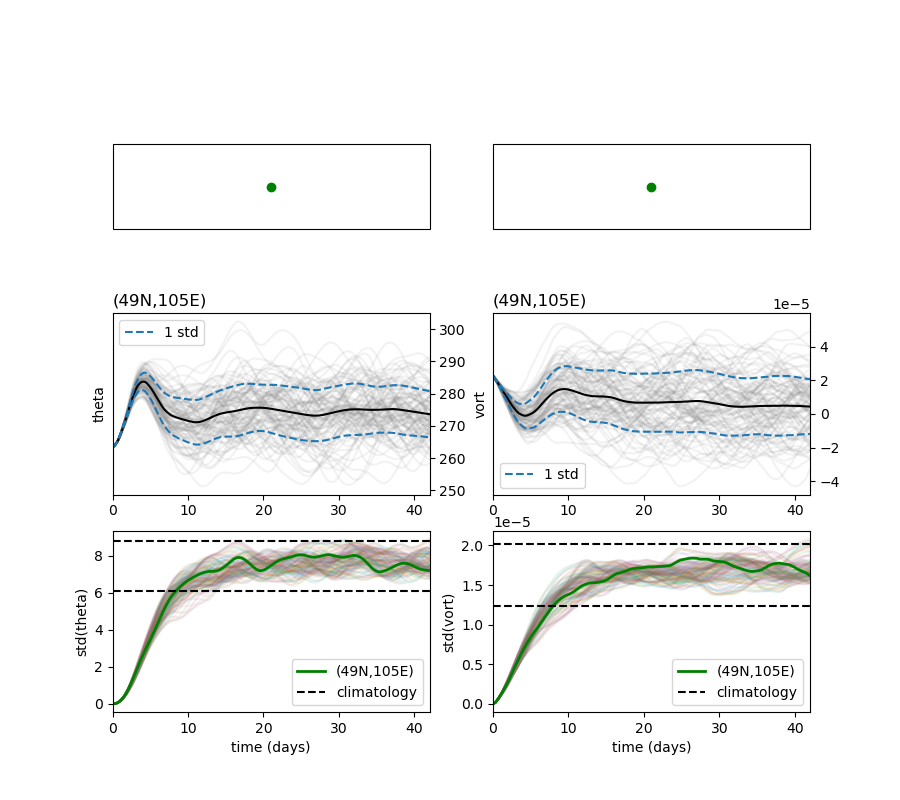

In [12]:
tidx=ensemble.time.size-1

s2d = 1/60./60./24.
fig = plt.figure(figsize=(9,8))
proj=ccrs.NorthPolarStereo()
xy=(105,50)

levels = [np.linspace(0,8,5), np.linspace(0,10,5)*0.1]

VOI = ['theta','vort'] #variables of interest

for i,var in enumerate(VOI):
    ax1 = plt.subplot(3,len(VOI),i+1, projection = proj) #axes for map
    ax2 = plt.subplot(3,len(VOI),i+3)
    ax3 = plt.subplot(3,len(VOI),i+5) #axes for discrete point

    
    ax1.scatter(x=xy[0], y=xy[1], color='g', transform = ccrs.PlateCarree())
    
    
    ens_point = ensemble[var].sel(x=xy[0], y=xy[1], method='nearest')
    
    #plot 2
    #ax2.set_title()
    ax2.set_title('({:.0f}N,{:.0f}E)'.format(float(ens_point.y),float(ens_point.x)),loc='left')
    ax2.plot(ensemble.time*s2d, ens_point.T, color='grey', alpha=0.1)
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem'), color='k')
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem') +ens_point.std('ens_mem'),
             color='tab:blue',linestyle='--')
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem') -ens_point.std('ens_mem'),
             color='tab:blue',linestyle='--', label = '1 std')
    
    #plot 3
    ax3.plot(ensemble.time*s2d,ensemble[var].sel(y=xy[1], method='nearest').std('ens_mem'), alpha=0.1)
    ax3.plot(ensemble.time*s2d, ens_point.std('ens_mem'),label='({:.0f}N,{:.0f}E)'.format(float(ens_point.y),float(ens_point.x)), color='g',linewidth=2)
    
    ax3.axhline(clims[var].sel(y=xy[1], method='nearest').mean(['x','runs']).values + 2*clims[var].sel(y=xy[1], method='nearest').std(['x','runs']).values,
                0,1, color = 'k', linestyle = '--', 
               label='climatology')
    ax3.axhline(clims[var].sel(y=xy[1], method='nearest').mean(['x','runs']).values - 2*clims[var].sel(y=xy[1], method='nearest').std(['x','runs']).values,
                0,1, color = 'k', linestyle = '--')


    ax2.yaxis.tick_right()
    ax3.set_xlabel('time (days)')
    ax3.set_ylabel("std({})".format(var))
    ax2.set_ylabel(var)
    ax2.set_xlim(0.,T*s2d)
    #ax3.set_ylim(0.,clims[var].sel(y=xy[1], method='nearest').max(['x','runs']).values)
    ax3.set_xlim(0.,T*s2d)
    ax3.legend()
    ax2.legend()
#fig.savefig('./images/ensemble_sim.png',dpi=300, bbox_inches='tight')    
plt.show()


### Above i've plotted the ensemble evolution for a single coordinate (second row). Spread is pretty large, but not too far off reality? Again, this is where we'd expect maximum stirring so having a std of ~8-9 K after 3 weeks seems reasonable if these represent atmospheric values.  The third row shows how every x-point at this latitude evolves in its ensemble std. +- 2 stds from the climatological mean are plotted with dashed lines. We see after about 3 weeks, most of the lons are within the bounds. Not exactly sure how to address those cases where some locations re-exit the climatological spread (see, for example, ~day 38 in vortp). Just need to integrate for longer?